In [294]:
# Imports 

from PIL import Image
import torch
import cv2
import matplotlib.pyplot as plt
import operator
import numpy as np
import math

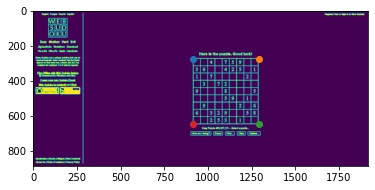

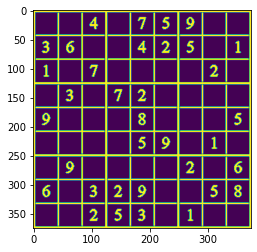

In [295]:
# Load image and convert into grayscale

img = cv2.imread("Sudoku_Grids/Grid1.png", cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Image modifications to highlight contours

img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
img = cv2.bitwise_not(img, img) 
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
img = cv2.dilate(img, kernel)

# Use CV2 to detect contours, identifying Sudoku grid within the image

contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

# Extrat corner points of the polygon

bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in
                      polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in
                  polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in
                     polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in
                   polygon]), key=operator.itemgetter(1))

pp = np.array([polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]])

# Snip image to match polygon size, obtaining Sudoku grid

img_n = img[min(pp[:, 1]):max(pp[:, 1]), min(pp[:, 0]):max(pp[:, 0]),]

# Visualisation

plt.imshow(img)
for p in pp:
    plt.scatter(p[0], p[1])
    
plt.show()
    
plt.imshow(img_n)

plt.show()

In [224]:
import torch
import torchvision
from torchvision import transforms

from torch import nn
import torch.nn.functional as F

# Network for digit detection

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
from IPython.display import clear_output

# Data transforms applied to MNIST dataset and subsequent images

trans=transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

data = torchvision.datasets.MNIST(".", download=True, train=True, transform=trans)

loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True)

# Train network on MNIST, only need 2 epochs as it is a very simple dataset

model = Net().cuda()
model.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2):
    for i, (img, lbl) in enumerate(loader):
        out = model.forward(img.cuda())
        loss = criterion(out, lbl.cuda())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        clear_output(wait=True)
        print(epoch, i, loss.item())

1 234 0.07980328053236008


In [117]:
# Evaluation script if desired, accuracy should be ~ 99%

test_data = torchvision.datasets.MNIST(".", download=True, train=False, transform=trans)

test_loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True)

model.eval()

corr = 0
tot = 0

for i, (img, lbl) in enumerate(ttloader):
    with torch.no_grad():
        
        out = model.forward(img.cuda()).topk(1)[-1].cpu()
        out = out.reshape(out.shape[0])
        corr += sum(out == lbl).item()
        tot += out.shape[0]

        
corr/tot

0.9893666666666666

In [225]:
# Used below for removing grid lines from each digit cell in the Sudoku grid

def find_edges(pic, V=0):
    x_s, x_e, y_s, y_e = 0, 49, 0, 49
    #x_s
    v = pic[25, x_s]
    while v > V:
        x_s += 1
        v = pic[25, x_s]
    #x_e
    v = pic[25, x_e]
    while v > V:
        x_e -= 1
        v = pic[25, x_e]
        
    #y_s
    v = pic[y_s, 25]
    while v > V:
        y_s += 1
        v = pic[y_s, 25]
    
    #y_e
    v = pic[y_e, 25]
    while v > V:
        y_e -= 1
        v = pic[y_e, 25]
        

    return pic[y_s:y_e, x_s:x_e]

In [313]:
# Resize grid and split into 9 sections along both axes, producing 81 subgrids

img_n = cv2.resize(img_n, (450, 450))
inner_box = int(img_n.shape[0]/9)

model.eval()
arr = []

# Iterate over each grid obtaining each digit which is appended into arr above.
# Cases with no digit corresponding to summed output of < 1000 return 0.

for y in range(9):
    in_arr = []
    for x in range(9):
        input_img = img_n[y*50:(y+1)*50, x*50:(x+1)*50]
        input_img = find_edges(input_img, V=0)
        if sum(input_img.flatten()) < 1000:
            pred = 0
        else:
            _, input_img = cv2.threshold(input_img, 125, 255,cv2.THRESH_BINARY)
            input_img = trans(Image.fromarray(input_img)).reshape(1, 1, 28, 28)
            out = model.forward(input_img.cuda())
            pred = out.topk(1)[-1].item()
            
            # Uncomment to display each digit which is classified
            
            #plt.imshow(input_img.reshape(28, 28))
            #plt.show()
            
        in_arr.append(pred)
    arr.append(in_arr)
    
arr = np.array(arr)

[[0 0 4 0 7 5 9 0 0]
 [3 6 0 0 4 2 5 0 1]
 [1 0 7 0 0 0 0 2 0]
 [0 3 0 7 2 0 0 0 0]
 [9 0 0 0 8 0 0 0 5]
 [0 0 0 0 5 9 0 1 0]
 [0 9 0 0 0 0 2 0 6]
 [6 0 3 2 9 0 0 5 8]
 [0 0 2 5 3 0 1 0 0]]


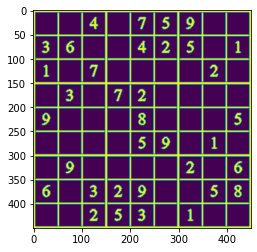

In [316]:
# Extracted and true array. 
# NOTE: There may be a discrepancy between the two depending on the font of the sudoku grid used, in such cases you can:
# 1.) Retry the classification above as this often solves the issue.
# 2.) Tweak the threshold parameter in the above code to make each digits thinner of thicker as this may affect the 
#     classification.
# 3.) Alter the numbers manually, typically most digits should be correct hence it may be easier to just modify the 
#     individual digits which are misclassified.

print(arr)
plt.imshow(img_n)

In [318]:
# Solver Backtracking Code

# Check if any subgrids are empty in need of filling.
# Update track parameter to the next empty subgrid.

def check_empty(arr, track):
    for i in range(9):
        for j in range(9):
            if arr[i, j] == 0:
                track[0] = i
                track[1] = j
                return True
    return False

# Check along row for validity of number

def check_row(row, num, arr):
    for i in range(9):
        if num == arr[row, i]:
            return False
    return True

# Check along column for validity of column

def check_col(col, num, arr):
    for i in range(9):
        if num == arr[i, col]:
            return False
    return True

# Locate 3x3 square of current subgrid

def locate_sq(col, row):
    col = math.floor(col/3)
    row = math.floor(row/3)
    
    return col, row

# Check validity of number inside its 3x3 square

def check_sq(col, row, num, arr):
    c, r = locate_sq(col, row)
    c = c * 3
    r = r * 3
    for i in range(r, r+3):
        for j in range(c, c+3):
            if num == arr[i, j]:
                return False
    return True

# Check overall validity of number at current location

def check_valid(row, col, num, arr):
    return check_row(row, num, arr) and check_col(col, num, arr) and check_sq(col, row, num, arr)


# Backtracking algorithm utilising the above functions

def solver(arr):
    track = [0, 0]   
    
    if not check_empty(arr, track):
        return True
    
    for num in range(1, 10):
        if check_valid(track[0], track[1], num, arr):
            
            arr[track[0], track[1]] = num
            
            if solver(arr):
                return True
                        
            arr[track[0], track[1]] = 0     
        
    return False

In [319]:
# Finally, the main execution code
# If you receive No Solutions this could indicate the misclassification of a digit by the CNN

if (solver(arr)):
    print(arr)
else:
    print("No Solutions !!!")

[[2 8 4 1 7 5 9 6 3]
 [3 6 9 8 4 2 5 7 1]
 [1 5 7 9 6 3 8 2 4]
 [5 3 1 7 2 4 6 8 9]
 [9 2 6 3 8 1 7 4 5]
 [4 7 8 6 5 9 3 1 2]
 [7 9 5 4 1 8 2 3 6]
 [6 1 3 2 9 7 4 5 8]
 [8 4 2 5 3 6 1 9 7]]
